#### Analyse de texte et traitement du langage naturel
inception

In [43]:
# import des bibliothèques
import requests
import lxml.html as lh
import pandas as pd
import csv
import re

import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
# scraping
url = 'http://www.allocine.fr/film/fichefilm-143692/critiques/spectateurs/'
uri_pages = '?page='
nbPages = 400
tags = ['//span[@class="stareval-note"]', \
        '//div[@class="content-txt review-card-content"]' ]
cols = ['Note', 'Description' ]
 
page = requests.get(url)
doc = lh.fromstring(page.content)

In [45]:
# definition
def getPage(url):
    page = requests.get(url)
    doc = lh.fromstring(page.content)
 
    # Get the Web data via XPath
    content = []
    for i in range(len(tags)):
        content.append(doc.xpath(tags[i]))
 
    # Gather the data into a Pandas DataFrame array
    df_liste = []
    for j in range(len(tags)):
        tmp = pd.DataFrame([content[j][i].text_content().strip() for i in range(len(content[i]))], columns=[cols[j]])
        tmp['key'] = tmp.index
        df_liste.append(tmp)
 
    # Build the unique Dataframe with one tag (xpath) content per column
    liste = df_liste[0]
    for j in range(len(tags)-1):
        liste = liste.join(df_liste[j+1], on='key', how='left', lsuffix='_l', rsuffix='_r')
        liste['key'] = liste.index
        del liste['key_l']
        del liste['key_r']
     
    return liste

#### Pagination

In [46]:
def getPages(_nbPages, _url):
    liste_finale = pd.DataFrame()
    for i in range (_nbPages):
        liste = getPage(_url + uri_pages + str(i+1))
        liste_finale = pd.concat([liste_finale, liste], ignore_index=True)
    return liste_finale
 
liste_totale = getPages(nbPages, url)

### création csv

In [47]:
liste_totale = getPages(nbPages, url)
liste_totale.to_csv('allocine_inception_avis_v2.csv', index=False, quoting=csv.QUOTE_NONNUMERIC)

In [48]:
pd.read_csv('allocine_inception_avis_V2.csv')

,Note,Description,key
0,"5,0",Après le chef d'oeuvre super-héroïque The Dark...,0
1,"5,0",C’est fou ce qu’on aime détester Christopher N...,1
2,"5,0",CHEF D’ŒUVRE ! Le film est absolument parfait ...,2
3,"5,0","Un film aussi novateur que complexe, dont la m...",3
4,"3,5",Le meilleur blockbuster de 2010 a pour thème l...,4
...,...,...,...
5995,"4,0",Superbe film. Très originale et plaisant à reg...,10
5996,"5,0","Ce film est très bien , mise a part les 30 pre...",11
5997,"5,0",Un film génialissime sous tous points: scénari...,12
5998,"4,0",Un point de vue intéressant du réalisateur qui...,13


### Etape 2 : Préparation des données

#### Retirer les bruits des commentaires
#### utiliser les expressions régulières

In [49]:
REMPLACE_SANS_ESPACE = re.compile("[;:!\'?,\"()\[\]]")
REMPLACE_AVEC_ESPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)|[.]")

def preprocess(txt):
    txt = [line.replace('\n', ' ')  for line in txt] # Retire les \n (retours chariots)
    txt = [REMPLACE_SANS_ESPACE.sub("", line.lower()) for line in txt]
    txt = [REMPLACE_AVEC_ESPACE.sub(" ", line) for line in txt]
    return txt

#### Simplification des données de commentaires

In [50]:
X = pd.read_csv('./allocine_inception_avis_V2.csv')

X['Description'] = pd.DataFrame(preprocess(X['Description']))
french_stopwords = set(stopwords.words('french'))
filtre_stopfr =  lambda text: [token for token in text if token.lower() not in french_stopwords]
X['Description'] = [' '.join(filtre_stopfr(word_tokenize(item))) for item in X['Description']]

stemmer = FrenchStemmer()
X['Description'] = [stemmer.stem(w) for w in X['Description']]

#### affichage des mots inutiles (stopwords)

In [51]:
print(french_stopwords)

{'seront', 'mon', 'sommes', 'eut', 'étantes', 'étants', 'de', 'mes', 'ayant', 'vos', 'ce', 'ait', 'le', 'ayons', 'aurez', 'aux', 'eue', 'est', 'fus', 'aura', 'fut', 'et', 'd', 'suis', 'été', 'étée', 'ou', 'étaient', 'ayants', 'auront', 'fussions', 'avions', 'ton', 'fussent', 'étais', 'ses', 'aient', 'ta', 'me', 'êtes', 'ces', 'soit', 'eus', 'eues', 'se', 'mais', 'notre', 'la', 'seras', 'toi', 'fût', 'eusse', 'un', 'au', 'aviez', 'ayante', 'seriez', 'furent', 'ayez', 'fusse', 'tu', 'son', 'nous', 'avec', 'avaient', 'tes', 'auras', 'as', 'aurait', 'avons', 'que', 'étiez', 'sera', 'c', 'serait', 'fussiez', 'les', 'dans', 'en', 'auraient', 'ma', 'serais', 'serez', 's', 'pour', 'qu', 't', 'était', 'serai', 'soyez', 'du', 'eussent', 'avez', 'eusses', 'je', 'n', 'sa', 'eu', 'qui', 'sont', 'ils', 'avait', 'serions', 'avais', 'étante', 'eurent', 'sois', 'on', 'auriez', 'fusses', 'aurais', 'l', 'aie', 'elle', 'te', 'ne', 'étés', 'ai', 'eussiez', 'seraient', 'une', 'aies', 'fûtes', 'pas', 'étions

In [52]:
for ok in X:
    print (ok)
    
X=X.drop('key',axis=1)
print("=======================")

for ok in X:
    print (ok)

Note
Description
key
Note
Description


### Etape 3: Préparation des libellés

In [53]:
def setClassBin(i):
    if (float(i.replace(',', '.')) > 3):
        return 1
    else:
        return 0
 
yList = [setClassBin(x) for x in X.Note]
y = pd.DataFrame(yList, columns=['classe'])
#X = X.drop('Note', axis=1)

In [54]:
print("Composition de X: \n")
for k in X:
    print(k)

print("====================================================")

print("Composition de y: \n")
for kk in y:
    print(kk)

print("====================================================")

print("Contenu de y[classe]: \n")
for kkk in y['classe']:
    print(kkk)

Composition de X: 

Note
Description
Composition de y: 

classe
Contenue de y[classe]: 

1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
0
1
0
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
0
0
1
0
0
0
1
0
0
1
1
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
0
1
0
0
0
0
0
1
1
1
1
1
1
1
0
1
0
0
1
1
1
1
1
1
0
1
1
0
0
1
0
0
0
0
0
0
0
1
1
0
1
1
1
0
0
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
0
1
1
0
1
1
1
1
1
1
1
1
1
0
1
1
0
0
1
0
0
1
1
1
0
1
0
1
1
1
1
1
0
1
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
0
0
1
1
1
0
0
0
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
0
0
0
1
1
1
0
1
1
1
1
1
0
0
0
0
0
1
1
0
0
0
1
1
1
0
0
0
1
1
1
1
0
0
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
1
1
0
0
0
1
1
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
0
0
1
0
1
0
1
1
1
1
0
1
1
1
0
1
1
0
1
1
0
1
1
0
1
1
0
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
0
0
0
0
1
1
1
0
1
1
1
0
1
0
0
0
1
0
1
1
1
1
1
1
1
1
1
0
1
1
1
1

In [55]:
print("Shape de y: ", y.shape)
print("Shape de X: ", X.shape)

Shape de y:  (6000, 1)
Shape de X:  (6000, 2)


In [56]:
print("Labels dans X: \n")
for a in X:
    print(a)
print("========================")
print("Labels dans y: \n")
for b in y:
    print(b)

Labels dans X: 

Note
Description
Labels dans y: 

classe


### Etape 4 : Finalisation du jeu de données

In [57]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X['Description'], y['classe'], test_size=0.2)

In [58]:
#for i in X_train:
#    print(i)

#print(type(X_train["Description"]))

In [59]:
for j in y_train:
    print(j)

1
1
1
1
1
1
1
0
1
0
1
1
1
1
0
0
1
1
1
1
0
0
1
0
1
1
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
0
1
0
1
1
1
1
0
0
0
1
1
1
0
1
1
1
1
1
1
0
0
1
1
1
1
0
0
0
1
1
1
1
1
1
1
0
0
1
1
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
0
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
0
1
1
0
0
1
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
1
1
0
1
0
0
1
1
1
1
0
1
1
0
1
1
0
1
1
1
1
1
1
1
0
1
1
0
1
0
1
1
0
1
1
1
1
1
0
1
1
0
0
0
1
1
1
1
1
0
1
1
1
1
1
1
1
0
1
0
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
0
0
0
0
0
1
1
0
1
0
1
1
0
0
1
1
1
1
0
1
0
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
0
1
1
1
0
1
1
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
0
1
0
0
1
1
1
0
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
0
1
1
1
1
1
1
0
1
1
1
1
0
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
0
0
1
1
0
1
1
1
1
1
0
1
1
0
0
1
1
1
0
1
1
1
0
1
1
1
1
0
0
1
1
1
0
1
1
1
1
1
1
1
1
1
1
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
0
1
1
0
1
0
1
1
1
0
1
1


In [60]:
#Vérifier le contenue car bug avec les espaces
#mis en com car trop de texte

#for op in X['Description']:
#    print (op)

#### Vectorisation des mots (sac de mots)

In [61]:
from sklearn.feature_extraction.text import CountVectorizer

Vectorizer = CountVectorizer(binary=True)
Vectorizer.fit(X_train)
 
X_train_vectorized = Vectorizer.transform(X_train)
X_test_vectorized = Vectorizer.transform(X_test)
pd.DataFrame(X_train_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,19432,19433,19434,19435,19436,19437,19438,19439,19440,19441
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4795,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4796,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4797,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Etape 5 : Entrainement du modèle

- hyperparamètre __c__ 
    - Objectif : trouver le meilleur

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


for c in [0.01, 0.05, 0.25, 0.5, 1]:
    logisRegre = LogisticRegression(C=c)
    logisRegre.fit(X_train_vectorized, y_train)
    print ("Précision pour C=%s: %s" % (c, accuracy_score(y_test, logisRegre.predict(X_test_vectorized))))
    



pred=logisRegre.predict(X_test_vectorized[1])
print(pred, y_test[1])

Précision pour C=0.01: 0.8275
Précision pour C=0.05: 0.8766666666666667
Précision pour C=0.25: 0.885
Précision pour C=0.5: 0.8858333333333334
Précision pour C=1: 0.8816666666666667
[1] 1


Meilleur paramètre c = 1

### Etape 6 : Analyse des résultats

- Entrainer le modèle à partir du paramètre c = 0.25

In [63]:
modele_final = LogisticRegression(C=1)
modele_final.fit(X_train_vectorized, y_train)


print ("Précision: %s" % accuracy_score(y_test, modele_final.predict(X_test_vectorized)))

Précision: 0.8816666666666667


<AxesSubplot:>

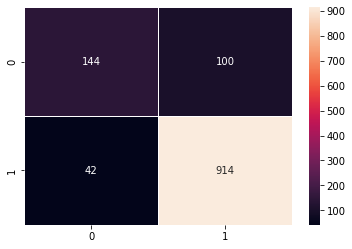

In [64]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = modele_final.predict(X_test_vectorized)

cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, linewidths=1, annot=True, fmt='g')